In [1]:
import os
import rootpath
import sys
sys.path.append(rootpath.detect())

import numpy as np
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# establish up data paths
try: 
    get_ipython().__class__.__name__
    script_dir = os.path.dirname(os.path.realpath(__file__))
except:
     script_dir = './'
if not os.path.isdir('./figures'):
    os.makedirs("./figures")

In [3]:
from scipy.stats import wilcoxon

In [4]:
import matplotlib
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import MaxNLocator


matplotlib.rcParams['mathtext.fontset'] = 'stix';
matplotlib.rcParams['font.family'] = 'STIXGeneral';
matplotlib.rcParams['font.size'] = 15 ;
matplotlib.rcParams['legend.fontsize'] = 11
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
def save_fig(fig, name=None):
    figname_stub = script_dir.split('/')[-1]
    if name is None:
        filename = figname_stub+"_"+fig.get_title()
    else:
        filename = figname_stub+"_"+name
    
    savedirs = [os.path.join(script_dir, "figures/"),
                "/home/finley/phd/papers/SAF-driven-EMO/figures/"]
    for d in savedirs:
        fig.savefig(os.path.join(d, filename+".png"), dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait', pad_inches=0.12)
        fig.savefig(os.path.join(d, filename+".pdf"), bbox_inches = 'tight', pad_inches = 0, dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait')
    

In [6]:
REPORT_TABLE_DIR= '/home/finley/phd/papers/SAF-driven-EMO/tables/'
X_LIMIT = 150

In [7]:
names = ['Mpoi', 'ParEgo', 'Saf_ei', 'Saf_$\\mu$', 'SmsEgo_ei', 'SmsEgo_$\\mu$', 'lhs', 'SmsEgoMu', 'SmsEgo']
true_names = ['MPoI', 'ParEGO', 'SAF$_{EI}$', 'SAF${\mu}$', 'SMS-EGO: ei old', 'SMS-EGO: $\mu$ old', 'LHS', 'SMS-EGO$_\mu$', "SMS-EGO"]

D_names = {a:b for a, b in zip(names, true_names)}

In [8]:
def add_com(df, mask, com):
    best_inds =  [*zip(*np.where(mask == 1))] 
    for i, j in best_inds:
        df.iloc[i, j] = com + df.iloc[i, j]
    return df

In [9]:
def IQR(dist, axis):
    return np.percentile(dist, 75, axis=axis) - np.percentile(dist, 25, axis=axis)

In [10]:
def gen_table(d, result_min=0, result_max=6):
    h, w = d.shape
    headers = pd.MultiIndex.from_product([[c.replace('_', ' ').replace('wfg', 'WFG').replace('obj', '$\nobj$').replace('dim', '$\ndim$') for c in chosen_results[result_min:result_max]], ['Median', 'IQR']])
    df = pd.DataFrame(data=d.round(3).astype(str), index=[D_names[o] for o in optimisers], columns=headers)
    return df, d

In [11]:
def gen_table_matrix(measure, result_min=0, result_max=6):
    if measure == 'igd+':
        invert=True
    else:
        invert=False
    # data matrix
    D = np.zeros((len(optimisers), len(chosen_results[result_min:result_max])*2))
    # mask of best values
    best_mask = np.zeros_like(D)
    # mask of equivalent values
    best_opts = []
    
    for i, prob in enumerate(chosen_results[result_min:result_max]):
        if invert:
            best_value = np.inf
        else:
            best_value = 0 
        best_index = 0
        for j, opt in enumerate(optimisers):
            med = np.median(results[prob]['data'][opt][measure], axis=0)[X_LIMIT]
            D[j, i*2] = med 
            D[j, i*2+1] = IQR(results[prob]['data'][opt][measure], axis=0)[X_LIMIT]
            if (med>best_value and invert == False) or (med<best_value and invert == True):
                best_value=med
                best_index = j
        best_mask[best_index, i*2] = True
        best_mask[best_index, i*2+1] = True
        best_opts.append(optimisers[best_index])
    
    eqv_mask = np.zeros_like(D)
    for i, prob in enumerate(chosen_results[result_min:result_max]):
        P = []
        for j, opt in enumerate(optimisers):
            if opt != best_opts[i]:
                hv = results[prob]['data'][opt][measure]
                bv = results[prob]['data'][best_opts[i]][measure]
                w, p = wilcoxon(bv[:, -1], hv[:, -1])
                P.append(p)
        p_inds = np.argsort(P)
        for ind, m in zip(p_inds, [r for r in range(len(P), 0, -1)]):
            if P[ind]>=(0.05/m):
                if optimisers[ind] == best_opts[i]:
                    pass
                else:
                    eqv_mask[ind, i*2] = True
                    eqv_mask[ind, i*2+1] = True
    return D, best_mask, eqv_mask

In [12]:
sw = ((31*(31+1)*(2*31+1))/6)**0.5 
sw

102.05880657738459

In [13]:
parent_dir = os.path.join(rootpath.detect(), 'experiments/data')

In [14]:
# sub_dirs = os.listdir(parent_dir)
sub_dirs  = ['wfg1_2obj_3dim',
            'wfg1_3obj_4dim',
            'wfg1_4obj_5dim',
            'wfg2_2obj_6dim',
            'wfg2_3obj_6dim',
            'wfg2_4obj_10dim',
            'wfg3_2obj_6dim',
            'wfg3_3obj_10dim',
            'wfg3_4obj_10dim',
            'wfg4_2obj_6dim',
            'wfg4_3obj_8dim',
            'wfg4_4obj_8dim',
            'wfg5_2obj_6dim',
            'wfg5_3obj_8dim',
            'wfg5_4obj_10dim',
            'wfg6_2obj_10dim',
            'wfg6_3obj_6dim',
            'wfg6_4obj_12dim']

In [15]:
results = {o:{'path':os.path.join(parent_dir, o, 'pkl_data/results__newsms.pkl')} for o in sub_dirs if o[:3] == 'wfg'}

In [16]:
for key, result in results.items():
    with open(result['path'], 'rb') as infile:
        results[key]['data'] = pkl.load(infile) 

In [17]:
chosen_results = sub_dirs

In [18]:
optimisers = [opt for opt in results[chosen_results[0]]['data'].keys() if opt not in ['SmsEgo_ei', 'SmsEgo_$\\mu$']]
optimisers

['Mpoi', 'ParEgo', 'Saf_ei', 'Saf_$\\mu$', 'SmsEgoMu', 'SmsEgo', 'lhs']

In [19]:
d, bm, em = gen_table_matrix('hypervolume', result_min=0, result_max=6)
T_hv_1= gen_table(d, result_min=0, result_max=6)[0]
T_hv_1[T_hv_1.columns[1::2]] = '\scriptsize \textit{'+T_hv_1[T_hv_1.columns[1::2]]+'}'
T_hv_1 = add_com(T_hv_1, bm, r'\best ')
T_hv_1 = add_com(T_hv_1, em, r'\statsimilar ')
with open(os.path.join(REPORT_TABLE_DIR, 'hv_table_1.tex'), "w") as outfile:
    print(T_hv_1.to_latex(index=True, escape=False), file=outfile)
T_hv_1

WFG1 2$\nobj$ 3$\ndim$                                           \
                              Median                                      IQR   
MPoI                           1.621               \scriptsize \textit{0.459}   
ParEGO                   \best 2.018         \best \scriptsize \textit{0.269}   
SAF$_{EI}$        \statsimilar 1.428  \statsimilar \scriptsize \textit{0.172}   
SAF${\mu}$                     1.976               \scriptsize \textit{0.234}   
SMS-EGO$_\mu$                  1.814               \scriptsize \textit{0.236}   
SMS-EGO                        1.827               \scriptsize \textit{0.161}   
LHS                            0.819               \scriptsize \textit{0.138}   

              WFG1 3$\nobj$ 4$\ndim$                                           \
                              Median                                      IQR   
MPoI                           6.242               \scriptsize \textit{1.507}   
ParEGO            \statsimilar 8.126  \statsimilar \scriptsize \textit{1.544}   
SAF$_{EI}$                     5.785               \scriptsize \textit{1.007}   
SAF${\mu}$        \statsimilar 7.972  \statsimilar \scriptsize \textit{1.855}   
SMS-EGO$_\mu$     \statsimilar 8.135  \statsimilar \scriptsize \textit{1.023}   
SMS-EGO                  \best 8.225          \best \scriptsize \textit{1.31}   
LHS                            2.925               \scriptsize \textit{0.397}   

              WFG1 4$\nobj$ 5$\ndim$                                           \
                              Median                                      IQR   
MPoI                          21.803               \scriptsize \textit{6.015}   
ParEGO             \statsimilar 29.0  \statsimilar \scriptsize \textit{3.865}   
SAF$_{EI}$                    23.685               \scriptsize \textit{2.684}   
SAF${\mu}$              \best 30.651         \best \scriptsize \textit{6.829}   
SMS-EGO$_\mu$     \statsimilar 30.33  \statsimilar \scriptsize \textit{9.137}   
SMS-EGO                       29.756               \scriptsize \textit{8.576}   
LHS                           11.582               \scriptsize \textit{1.726}   

              WFG2 2$\nobj$ 6$\ndim$                                    \
                              Median                               IQR   
MPoI                           7.551        \scriptsize \textit{1.386}   
ParEGO                   \best 8.546  \best \scriptsize \textit{0.439}   
SAF$_{EI}$                     7.742        \scriptsize \textit{0.553}   
SAF${\mu}$                     7.979        \scriptsize \textit{0.425}   
SMS-EGO$_\mu$                  7.826        \scriptsize \textit{0.673}   
SMS-EGO                        7.708        \scriptsize \textit{0.914}   
LHS                            7.993        \scriptsize \textit{0.395}   

              WFG2 3$\nobj$ 6$\ndim$                                    \
                              Median                               IQR   
MPoI                    \best 74.854  \best \scriptsize \textit{7.323}   
ParEGO                         74.33        \scriptsize \textit{4.332}   
SAF$_{EI}$                    70.924        \scriptsize \textit{4.325}   
SAF${\mu}$                    72.149        \scriptsize \textit{6.855}   
SMS-EGO$_\mu$                 68.103        \scriptsize \textit{8.318}   
SMS-EGO                       68.408        \scriptsize \textit{5.308}   
LHS                           66.546        \scriptsize \textit{4.424}   

              WFG2 4$\nobj$ 10$\ndim$                                     
                               Median                                IQR  
MPoI                          560.122        \scriptsize \textit{52.447}  
ParEGO                  \best 581.771  \best \scriptsize \textit{47.669}  
SAF$_{EI}$                    543.311        \scriptsize \textit{50.594}  
SAF${\mu}$                    527.018        \scriptsize \textit{81.294}  
SMS-EGO$_\mu$                 528.554   

In [20]:
d, bm, em = gen_table_matrix('hypervolume', result_min=6, result_max=12)
T_hv_2= gen_table(d, result_min=6, result_max=12)[0]
T_hv_2[T_hv_2.columns[1::2]] = '\scriptsize \textit{'+T_hv_2[T_hv_2.columns[1::2]]+'}'
T_hv_2 = add_com(T_hv_2, bm, r'\best ')
T_hv_2 = add_com(T_hv_2, em, r'\statsimilar ')
with open(os.path.join(REPORT_TABLE_DIR, 'hv_table_2.tex'), "w") as outfile:
    print(T_hv_2.to_latex(index=True, escape=False), file=outfile)
T_hv_2

WFG3 2$\nobj$ 6$\ndim$                                    \
                              Median                               IQR   
MPoI                           8.797         \scriptsize \textit{0.84}   
ParEGO                         9.299        \scriptsize \textit{0.309}   
SAF$_{EI}$                    10.107        \scriptsize \textit{0.154}   
SAF${\mu}$                    10.557        \scriptsize \textit{0.054}   
SMS-EGO$_\mu$                 10.605        \scriptsize \textit{0.067}   
SMS-EGO                 \best 10.642  \best \scriptsize \textit{0.058}   
LHS                            7.929        \scriptsize \textit{0.262}   

              WFG3 3$\nobj$ 10$\ndim$                                    \
                               Median                               IQR   
MPoI                           59.129        \scriptsize \textit{7.415}   
ParEGO                         62.675        \scriptsize \textit{3.605}   
SAF$_{EI}$                     66.207        \scriptsize \textit{1.344}   
SAF${\mu}$                     67.455        \scriptsize \textit{1.482}   
SMS-EGO$_\mu$            \best 68.712  \best \scriptsize \textit{0.999}   
SMS-EGO                        68.311         \scriptsize \textit{1.85}   
LHS                            50.393        \scriptsize \textit{1.723}   

              WFG3 4$\nobj$ 10$\ndim$                                     \
                               Median                                IQR   
MPoI                          505.153        \scriptsize \textit{28.342}   
ParEGO                        500.097        \scriptsize \textit{20.609}   
SAF$_{EI}$              \best 536.895  \best \scriptsize \textit{10.789}   
SAF${\mu}$                    533.867        \scriptsize \textit{15.715}   
SMS-EGO$_\mu$                 514.673        \scriptsize \textit{30.579}   
SMS-EGO                       519.061        \scriptsize \textit{31.821}   
LHS                           412.862        \scriptsize \textit{15.205}   

              WFG4 2$\nobj$ 6$\ndim$                                           \
                              Median                                      IQR   
MPoI                           6.357               \scriptsize \textit{0.485}   
ParEGO            \statsimilar 7.228  \statsimilar \scriptsize \textit{0.312}   
SAF$_{EI}$        \statsimilar 7.231   \statsimilar \scriptsize \textit{0.38}   
SAF${\mu}$        \statsimilar 7.303  \statsimilar \scriptsize \textit{0.494}   
SMS-EGO$_\mu$      \statsimilar 7.35  \statsimilar \scriptsize \textit{0.372}   
SMS-EGO                  \best 7.373         \best \scriptsize \textit{0.401}   
LHS                            6.019               \scriptsize \textit{0.348}   

              WFG4 3$\nobj$ 8$\ndim$                                           \
                              Median                                      IQR   
MPoI                          49.458               \scriptsize \textit{4.523}   
ParEGO                        52.602               \scriptsize \textit{9.036}   
SAF$_{EI}$       \statsimilar 56.488  \statsimilar \scriptsize \textit{3.066}   
SAF${\mu}$        \statsimilar 55.83  \statsimilar \scriptsize \textit{2.976}   
SMS-EGO$_\mu$           \best 57.425         \best \scriptsize \textit{6.025}   
SMS-EGO                       52.681               \scriptsize \textit{8.842}   
LHS                            38.42               \scriptsize \textit{2.486}   

              WFG4 4$\nobj$ 8$\ndim$                                            
                              Median                                       IQR  
MPoI                         447.613              \scriptsize \textit{149.491}  
ParEGO                       489.206              \scriptsize \textit{133.452}  
SAF$_{EI}$      \statsimilar 537.971  \statsimilar \scriptsize \textit{44.804}  
SAF${\mu}$      \statsimilar 558.712  \statsimilar \scriptsize \textit{35.838}  
SMS-EGO$_\mu$          \best 560.487    

In [21]:
d, bm, em = gen_table_matrix('hypervolume', result_min=12, result_max=18)
T_hv_3= gen_table(d, result_min=12, result_max=18)[0]
T_hv_3[T_hv_3.columns[1::2]] = '\scriptsize \textit{'+T_hv_3[T_hv_3.columns[1::2]]+'}'
T_hv_3 = add_com(T_hv_3, bm, r'\best ')
T_hv_3 = add_com(T_hv_3, em, r'\statsimilar ')
with open(os.path.join(REPORT_TABLE_DIR, 'hv_table_3.tex'), "w") as outfile:
    print(T_hv_3.to_latex(index=True, escape=False), file=outfile)
    
T_hv_3

WFG5 2$\nobj$ 6$\ndim$                                           \
                              Median                                      IQR   
MPoI                           5.824               \scriptsize \textit{0.511}   
ParEGO                   \best 6.563         \best \scriptsize \textit{0.331}   
SAF$_{EI}$                     5.296               \scriptsize \textit{0.365}   
SAF${\mu}$                     6.158               \scriptsize \textit{0.388}   
SMS-EGO$_\mu$     \statsimilar 6.007  \statsimilar \scriptsize \textit{0.554}   
SMS-EGO                        6.476               \scriptsize \textit{0.603}   
LHS                            4.827               \scriptsize \textit{0.231}   

              WFG5 3$\nobj$ 8$\ndim$                                           \
                              Median                                      IQR   
MPoI                          39.407               \scriptsize \textit{6.264}   
ParEGO                        40.123                \scriptsize \textit{5.34}   
SAF$_{EI}$                    36.186               \scriptsize \textit{4.429}   
SAF${\mu}$       \statsimilar 42.468  \statsimilar \scriptsize \textit{3.608}   
SMS-EGO$_\mu$    \statsimilar 42.788    \statsimilar \scriptsize \textit{3.6}   
SMS-EGO                 \best 43.535         \best \scriptsize \textit{5.494}   
LHS                           30.024               \scriptsize \textit{1.435}   

              WFG5 4$\nobj$ 10$\ndim$                                     \
                               Median                                IQR   
MPoI                          262.216        \scriptsize \textit{58.982}   
ParEGO                         279.99        \scriptsize \textit{47.968}   
SAF$_{EI}$                    261.256         \scriptsize \textit{33.69}   
SAF${\mu}$              \best 324.422  \best \scriptsize \textit{35.089}   
SMS-EGO$_\mu$                 281.026        \scriptsize \textit{56.622}   
SMS-EGO                       281.539        \scriptsize \textit{50.995}   
LHS                           212.412         \scriptsize \textit{10.44}   

              WFG6 2$\nobj$ 10$\ndim$                                    \
                               Median                               IQR   
MPoI                            6.266        \scriptsize \textit{0.468}   
ParEGO                          7.026        \scriptsize \textit{0.382}   
SAF$_{EI}$                      7.242        \scriptsize \textit{0.294}   
SAF${\mu}$                \best 7.636  \best \scriptsize \textit{0.404}   
SMS-EGO$_\mu$                    6.78        \scriptsize \textit{0.846}   
SMS-EGO                         6.942        \scriptsize \textit{0.718}   
LHS                             4.461        \scriptsize \textit{0.223}   

              WFG6 3$\nobj$ 6$\ndim$                                    \
                              Median                               IQR   
MPoI                          61.134        \scriptsize \textit{5.597}   
ParEGO                        54.838        \scriptsize \textit{2.688}   
SAF$_{EI}$                    63.811        \scriptsize \textit{4.398}   
SAF${\mu}$              \best 69.028  \best \scriptsize \textit{1.866}   
SMS-EGO$_\mu$                 63.657        \scriptsize \textit{7.053}   
SMS-EGO                       64.476        \scriptsize \textit{5.202}   
LHS                           44.089        \scriptsize \textit{2.789}   

              WFG6 4$\nobj$ 12$\ndim$                                     
                               Median                                IQR  
MPoI                          392.953        \scriptsize \textit{68.695}  
ParEGO                        411.117        \scriptsize \textit{60.737}  
SAF$_{EI}$                    432.901        \scriptsize \textit{18.499}  
SAF${\mu}$                    445.447        \scriptsize \textit{33.157}  
SMS-EGO$_\mu$           \best 492.477  \best \scriptsize \textit{31.253}  
S

In [22]:
d, bm, em = gen_table_matrix('igd+', result_min=0, result_max=6)
T_igd_1= gen_table(d, result_min=0, result_max=6)[0]
T_igd_1[T_igd_1.columns[1::2]] = '\scriptsize \textit{'+T_igd_1[T_igd_1.columns[1::2]]+'}'
T_igd_1 = add_com(T_igd_1, bm, r'\best ')
T_igd_1 = add_com(T_igd_1, em, r'\statsimilar ')
with open(os.path.join(REPORT_TABLE_DIR, 'igd_table_1.tex'), "w") as outfile:
    print(T_igd_1.to_latex(index=True, escape=False), file=outfile)
    
T_igd_1

WFG1 2$\nobj$ 3$\ndim$                                           \
                              Median                                      IQR   
MPoI                           1.063               \scriptsize \textit{0.269}   
ParEGO                   \best 0.969         \best \scriptsize \textit{0.036}   
SAF$_{EI}$                     1.324               \scriptsize \textit{0.067}   
SAF${\mu}$        \statsimilar 1.014  \statsimilar \scriptsize \textit{0.035}   
SMS-EGO$_\mu$                  0.992               \scriptsize \textit{0.035}   
SMS-EGO                        0.993               \scriptsize \textit{0.035}   
LHS                            1.565               \scriptsize \textit{0.055}   

              WFG1 3$\nobj$ 4$\ndim$                                           \
                              Median                                      IQR   
MPoI                           1.483               \scriptsize \textit{0.231}   
ParEGO            \statsimilar 1.318  \statsimilar \scriptsize \textit{0.113}   
SAF$_{EI}$                     1.636                 \scriptsize \textit{0.1}   
SAF${\mu}$        \statsimilar 1.343  \statsimilar \scriptsize \textit{0.184}   
SMS-EGO$_\mu$            \best 1.297         \best \scriptsize \textit{0.093}   
SMS-EGO                        1.314               \scriptsize \textit{0.113}   
LHS                            2.001               \scriptsize \textit{0.048}   

              WFG1 4$\nobj$ 5$\ndim$                                           \
                              Median                                      IQR   
MPoI                           1.883               \scriptsize \textit{0.187}   
ParEGO            \statsimilar 1.655  \statsimilar \scriptsize \textit{0.149}   
SAF$_{EI}$                     1.814               \scriptsize \textit{0.128}   
SAF${\mu}$        \statsimilar 1.621  \statsimilar \scriptsize \textit{0.187}   
SMS-EGO$_\mu$            \best 1.614         \best \scriptsize \textit{0.286}   
SMS-EGO                        1.634               \scriptsize \textit{0.248}   
LHS                            2.289               \scriptsize \textit{0.066}   

              WFG2 2$\nobj$ 6$\ndim$                                    \
                              Median                               IQR   
MPoI                           0.561         \scriptsize \textit{0.22}   
ParEGO                   \best 0.433  \best \scriptsize \textit{0.083}   
SAF$_{EI}$                     0.553        \scriptsize \textit{0.094}   
SAF${\mu}$                      0.53        \scriptsize \textit{0.101}   
SMS-EGO$_\mu$                  0.538        \scriptsize \textit{0.129}   
SMS-EGO                         0.57         \scriptsize \textit{0.15}   
LHS                            0.493        \scriptsize \textit{0.076}   

              WFG2 3$\nobj$ 6$\ndim$                                    \
                              Median                               IQR   
MPoI                     \best 0.653  \best \scriptsize \textit{0.161}   
ParEGO                         0.746        \scriptsize \textit{0.201}   
SAF$_{EI}$                     0.891        \scriptsize \textit{0.212}   
SAF${\mu}$                     0.818        \scriptsize \textit{0.258}   
SMS-EGO$_\mu$                  0.889        \scriptsize \textit{0.217}   
SMS-EGO                        0.878        \scriptsize \textit{0.192}   
LHS                            0.838        \scriptsize \textit{0.186}   

              WFG2 4$\nobj$ 10$\ndim$                                           
                               Median                                      IQR  
MPoI                            0.652               \scriptsize \textit{0.178}  
ParEGO              \statsimilar 0.55  \statsimilar \scriptsize \textit{0.159}  
SAF$_{EI}$                      0.646               \scriptsize \textit{0.208}  
SAF${\mu}$                      0.639               \scriptsize \textit{0.224}  
SMS-

In [23]:
d, bm, em = gen_table_matrix('igd+', result_min=6, result_max=12)
T_igd_2= gen_table(d, result_min=6, result_max=12)[0]
T_igd_2[T_igd_2.columns[1::2]] = '\scriptsize \textit{'+T_igd_2[T_igd_2.columns[1::2]]+'}'
T_igd_2 = add_com(T_igd_2, bm, r'\best ')
T_igd_2 = add_com(T_igd_2, em, r'\statsimilar ')

with open(os.path.join(REPORT_TABLE_DIR, 'igd_table_2.tex'), "w") as outfile:
    print(T_igd_2.to_latex(index=True, escape=False), file=outfile)
T_igd_2

WFG3 2$\nobj$ 6$\ndim$                                    \
                              Median                               IQR   
MPoI                            0.28        \scriptsize \textit{0.129}   
ParEGO                         0.242        \scriptsize \textit{0.052}   
SAF$_{EI}$                     0.112        \scriptsize \textit{0.031}   
SAF${\mu}$                     0.046         \scriptsize \textit{0.01}   
SMS-EGO$_\mu$                  0.042        \scriptsize \textit{0.012}   
SMS-EGO                  \best 0.038  \best \scriptsize \textit{0.006}   
LHS                            0.418        \scriptsize \textit{0.047}   

              WFG3 3$\nobj$ 10$\ndim$                                   \
                               Median                              IQR   
MPoI                            0.402       \scriptsize \textit{0.222}   
ParEGO                          0.336       \scriptsize \textit{0.211}   
SAF$_{EI}$                      0.222       \scriptsize \textit{0.068}   
SAF${\mu}$                      0.162       \scriptsize \textit{0.042}   
SMS-EGO$_\mu$             \best 0.131  \best \scriptsize \textit{0.04}   
SMS-EGO                         0.136       \scriptsize \textit{0.053}   
LHS                             0.613       \scriptsize \textit{0.056}   

              WFG3 4$\nobj$ 10$\ndim$                                    \
                               Median                               IQR   
MPoI                            0.293        \scriptsize \textit{0.138}   
ParEGO                          0.408         \scriptsize \textit{0.11}   
SAF$_{EI}$                      0.274        \scriptsize \textit{0.057}   
SAF${\mu}$                \best 0.241  \best \scriptsize \textit{0.069}   
SMS-EGO$_\mu$                   0.303        \scriptsize \textit{0.109}   
SMS-EGO                         0.298        \scriptsize \textit{0.086}   
LHS                              0.66        \scriptsize \textit{0.071}   

              WFG4 2$\nobj$ 6$\ndim$                                           \
                              Median                                      IQR   
MPoI                           0.296               \scriptsize \textit{0.076}   
ParEGO                          0.19               \scriptsize \textit{0.047}   
SAF$_{EI}$         \statsimilar 0.17  \statsimilar \scriptsize \textit{0.032}   
SAF${\mu}$        \statsimilar 0.166  \statsimilar \scriptsize \textit{0.054}   
SMS-EGO$_\mu$     \statsimilar 0.168  \statsimilar \scriptsize \textit{0.039}   
SMS-EGO                  \best 0.162         \best \scriptsize \textit{0.044}   
LHS                            0.316               \scriptsize \textit{0.063}   

              WFG4 3$\nobj$ 8$\ndim$                                           \
                              Median                                      IQR   
MPoI                           0.554               \scriptsize \textit{0.085}   
ParEGO                         0.545               \scriptsize \textit{0.166}   
SAF$_{EI}$               \best 0.403         \best \scriptsize \textit{0.042}   
SAF${\mu}$        \statsimilar 0.411  \statsimilar \scriptsize \textit{0.054}   
SMS-EGO$_\mu$     \statsimilar 0.415  \statsimilar \scriptsize \textit{0.114}   
SMS-EGO                        0.493               \scriptsize \textit{0.193}   
LHS                             0.88               \scriptsize \textit{0.112}   

              WFG4 4$\nobj$ 8$\ndim$                                           
                              Median                                      IQR  
MPoI                           0.889               \scriptsize \textit{0.591}  
ParEGO                         0.863               \scriptsize \textit{0.394}  
SAF$_{EI}$        \statsimilar 0.656  \statsimilar \scriptsize \textit{0.135}  
SAF${\mu}$               \best 0.622         \best \scriptsize \textit{0.096}  
SMS-EGO$_\mu$                  0.633               \scriptsize \

In [24]:
d, bm, em = gen_table_matrix('igd+', result_min=12, result_max=18)
T_igd_3= gen_table(d, result_min=12, result_max=18)[0]
T_igd_3[T_igd_3.columns[1::2]] = '\scriptsize \textit{'+T_igd_3[T_igd_3.columns[1::2]]+'}'
T_igd_3 = add_com(T_igd_3, bm, r'\best ')
T_igd_3 = add_com(T_igd_3, em, r'\statsimilar ')
with open(os.path.join(REPORT_TABLE_DIR, 'igd_table_3.tex'), "w") as outfile:
    print(T_igd_3.to_latex(index=True, escape=False), file=outfile)
T_igd_3

WFG5 2$\nobj$ 6$\ndim$                                    \
                              Median                               IQR   
MPoI                           0.229        \scriptsize \textit{0.099}   
ParEGO                         0.141        \scriptsize \textit{0.044}   
SAF$_{EI}$                     0.325        \scriptsize \textit{0.069}   
SAF${\mu}$                     0.178        \scriptsize \textit{0.064}   
SMS-EGO$_\mu$                   0.19        \scriptsize \textit{0.092}   
SMS-EGO                  \best 0.131  \best \scriptsize \textit{0.073}   
LHS                            0.422        \scriptsize \textit{0.046}   

              WFG5 3$\nobj$ 8$\ndim$                                           \
                              Median                                      IQR   
MPoI                           0.583               \scriptsize \textit{0.203}   
ParEGO                         0.539               \scriptsize \textit{0.126}   
SAF$_{EI}$                      0.69               \scriptsize \textit{0.214}   
SAF${\mu}$        \statsimilar 0.458  \statsimilar \scriptsize \textit{0.121}   
SMS-EGO$_\mu$     \statsimilar 0.441  \statsimilar \scriptsize \textit{0.117}   
SMS-EGO                  \best 0.434          \best \scriptsize \textit{0.15}   
LHS                            0.778               \scriptsize \textit{0.073}   

              WFG5 4$\nobj$ 10$\ndim$                                    \
                               Median                               IQR   
MPoI                            1.182         \scriptsize \textit{0.37}   
ParEGO                           1.09        \scriptsize \textit{0.289}   
SAF$_{EI}$                      1.251        \scriptsize \textit{0.341}   
SAF${\mu}$                \best 0.872  \best \scriptsize \textit{0.188}   
SMS-EGO$_\mu$                   1.132        \scriptsize \textit{0.452}   
SMS-EGO                           1.2        \scriptsize \textit{0.448}   
LHS                             1.254        \scriptsize \textit{0.092}   

              WFG6 2$\nobj$ 10$\ndim$                                    \
                               Median                               IQR   
MPoI                            0.365        \scriptsize \textit{0.094}   
ParEGO                          0.252        \scriptsize \textit{0.072}   
SAF$_{EI}$                      0.201        \scriptsize \textit{0.064}   
SAF${\mu}$                \best 0.123  \best \scriptsize \textit{0.062}   
SMS-EGO$_\mu$                   0.238        \scriptsize \textit{0.125}   
SMS-EGO                         0.232        \scriptsize \textit{0.129}   
LHS                             0.636        \scriptsize \textit{0.049}   

              WFG6 3$\nobj$ 6$\ndim$                                    \
                              Median                               IQR   
MPoI                           0.354        \scriptsize \textit{0.122}   
ParEGO                         0.556        \scriptsize \textit{0.078}   
SAF$_{EI}$                     0.319        \scriptsize \textit{0.094}   
SAF${\mu}$               \best 0.203  \best \scriptsize \textit{0.043}   
SMS-EGO$_\mu$                   0.36        \scriptsize \textit{0.175}   
SMS-EGO                        0.351        \scriptsize \textit{0.129}   
LHS                            0.691        \scriptsize \textit{0.063}   

              WFG6 4$\nobj$ 12$\ndim$                                           
                               Median                                      IQR  
MPoI               \statsimilar 0.893  \statsimilar \scriptsize \textit{0.206}  
ParEGO                          1.034               \scriptsize \textit{0.209}  
SAF$_{EI}$                      0.929               \scriptsize \textit{0.063}  
SAF${\mu}$         \statsimilar 0.809  \statsimilar \scriptsize \textit{0.088}  
SMS-EGO$_\mu$             \best 0.774         \best \scriptsize \textit{0.092}  
SMS-EGO                        

In [25]:
print(T_igd_3.to_latex(index=True, escape=False))

\begin{tabular}{lllllllllllll}
\toprule
{} & \multicolumn{2}{l}{WFG5 2$\nobj$ 6$\ndim$} & \multicolumn{2}{l}{WFG5 3$\nobj$ 8$\ndim$} & \multicolumn{2}{l}{WFG5 4$\nobj$ 10$\ndim$} & \multicolumn{2}{l}{WFG6 2$\nobj$ 10$\ndim$} & \multicolumn{2}{l}{WFG6 3$\nobj$ 6$\ndim$} & \multicolumn{2}{l}{WFG6 4$\nobj$ 12$\ndim$} \\
{} &                 Median &                               IQR &                 Median &                                      IQR &                  Median &                               IQR &                  Median &                               IQR &                 Median &                               IQR &                  Median &                                      IQR \\
\midrule
MPoI          &                  0.229 &        \scriptsize \textit{0.099} &                  0.583 &               \scriptsize \textit{0.203} &                   1.182 &         \scriptsize \textit{0.37} &                   0.365 &        \scriptsize \textit{0.094} &               

- for each problem
    - extract hypervolume data - (7, 31, 250)
    - find medians
    - rank -  (7, 250)
    - find best - (250,)
    - find p values
    - divy rankings
    - sum rans
- do for all opts
- sum

In [29]:
def extract_metric(results, F_name, metric):
    """
    gets a numpy array of data according to the passed metric
    
    :params:
    result dict: dictionary of resukts
    F_name str: test_function name
    metric str: metric to be extracted, either 'hypervolume' or 'igd+'
    
    :returns:
    np.ndarray (n_optimisers, n_repeats, 250) hypervolume data
    """
    # get function specific data 
    F_data = results[F_name]['data']
    
    # extract metric data for all optimisers, clipping lhs to size
    hv_data = np.array([d[metric] if k !="lhs" else d['hypervolume'][:,1:] for k, d in F_data.items() ])
    return hv_data

def rank_metrics(metric, minimise=False):
    meds = np.median(metric, axis=1)
    if minimise:
        best_inds = np.argmin(meds, axis=0)
    else:
        best_inds = np.argmax(meds, axis=0)
    
    if minimise:
        return np.argsort(meds, axis=0).argsort(axis=0), best_inds
    else: 
        return np.argsort(meds, axis=0)[::-1].argsort(axis=0), best_inds

def get_equivalence_single(data, minimise=False):
    assert data.shape == (9, 31)
    ranks, best = rank_metrics(data, minimise=minimise)
    
    for pairing in range(1, ranks.max()):
        w, p = wilcoxon(data[pairing-1], data[pairing])
        if p>0.05:
            ranks[ranks<pairing] = ranks[ranks<pairing]+1
    return ranks-ranks.min()+1


def get_equivalence(data, minimise=False):
    assert data.ndim == 3
    
    ranks = np.zeros((data.shape[0], data.shape[-1]))
    for i in range(data.shape[-1]):
        mod_rank =  get_equivalence_single(data[:,:,i], minimise=minimise)
        ranks[:,i] = mod_rank
    return ranks

In [31]:
HVS = np.zeros((18, 9, 140))
for i, prob in enumerate(chosen_results):
    hvs = extract_metric(results, prob, 'hypervolume')[:, :,10:150]
    rs = get_equivalence(hvs)
    HVS[i] = rs 
HVS.shape

(18, 9, 140)

In [33]:
IGDS = np.zeros((18, 9, 150))
for i, opt in enumerate(chosen_results):
    igds = extract_metric(results, opt, 'igd+')[:, :,0:150]
    rs = get_equivalence(igds, minimise=True)
    IGDS[i] = rs 
IGDS.shape

(18, 9, 150)

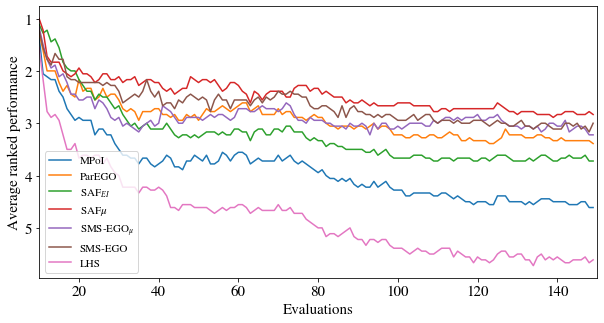

In [39]:
ans = HVS.sum(axis=0)
fig = plt.figure(figsize=[10, 5])
ax = fig.gca()
for a , name in zip(ans, results['wfg5_4obj_10dim']['data'].keys()):
    if name not in ['SmsEgo_$\\mu$', 'SmsEgo_ei']:
        ax.plot(range(10, len(a)+10), a/18, label=D_names[name])
ax.invert_yaxis()
ax.set_xlim([10,150])
ax.set_ylabel('Average ranked performance')
ax.set_xlabel('Evaluations')
ax.legend()

In [ ]:
# save_fig(fig, name="ranked_performance_plot_hv")

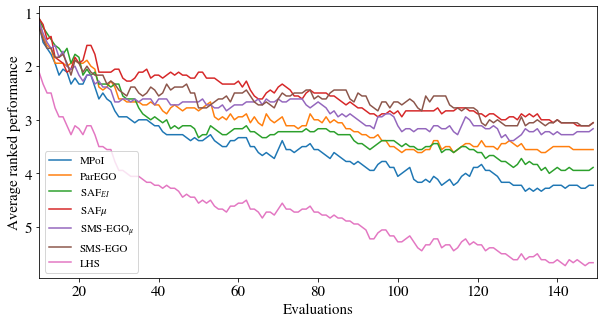

In [38]:
ans = IGDS.sum(axis=0)
fig = plt.figure(figsize=[10, 5])
ax = fig.gca()
for a , name in zip(ans, results['wfg5_4obj_10dim']['data'].keys()):
    if name not in ['SmsEgo_$\\mu$', 'SmsEgo_ei']:
        ax.plot(range(10, len(a)), a[10:]/18, label=D_names[name])
ax.invert_yaxis()
ax.set_xlim([10,150])
ax.set_ylabel('Average ranked performance')
ax.set_xlabel('Evaluations')
ax.legend()

In [ ]:
# save_fig(fig, name="ranked_performance_plot_igd")

In [ ]:
for r in results['wfg1_2obj_3dim']['data'].keys():
    print(r)

In [ ]:
# greedy vs ei winners SAF HV
hvs = np.array([extract_metric(results, f, 'hypervolume')[:, :,10:151] for f in chosen_results])
hvs_saf_vs = hvs[:, [2, 3], :, -1]
np.array(chosen_results)[np.invert(np.median(hvs_saf_vs, axis=-1).argmax(axis=0).astype(bool))]

In [ ]:
# greedy vs ei winners SMS HV
hvs = np.array([extract_metric(results, f, 'hypervolume')[:, :,10:151] for f in chosen_results])
hvs_saf_vs = hvs[:, [4, 5], :, -1]
np.array(chosen_results)[np.invert(np.median(hvs_saf_vs, axis=-1).argmax(axis=0).astype(bool))]

In [ ]:
# greedy vs ei winners SAF HV
igd = np.array([extract_metric(results, f, 'igd+')[:, :,10:151] for f in chosen_results])
igd_saf_vs = igd[:, [2, 3], :, -1]
np.array(chosen_results)[np.invert(np.median(igd_saf_vs, axis=-1).argmin(axis=0).astype(bool))]

In [ ]:
# greedy vs ei winners SAF HV
igd = np.array([extract_metric(results, f, 'igd+')[:, :,10:151] for f in chosen_results])
igd_saf_vs = igd[:, [4, 5], :, -1]
np.array(chosen_results)[np.invert(np.median(igd_saf_vs, axis=-1).argmin(axis=0).astype(bool))]